In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


from lerobot.policies.smolandfast.tokenizer import Autoencoder
from torch.optim.lr_scheduler import CosineAnnealingLR

from pathlib import Path
from tqdm import tqdm
import torch
from lerobot.datasets.utils import cycle

from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.smolandfast.configuration_smolandfast import SMOLANDFASTConfig
from lerobot.policies.smolandfast.modeling_smolandfast import SMOLANDFASTPolicy

from lerobot.policies.factory import make_pre_post_processors
import matplotlib.pyplot as plt
from auraloss.freq import STFTLoss

/lerobot-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_directory = Path("outputs/train/example_pusht")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda")

In [3]:
DATASET_PATH = "lerobot/pusht"

dataset_metadata = LeRobotDatasetMetadata(DATASET_PATH)
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

cfg = SMOLANDFASTConfig(input_features=input_features,
                        output_features=output_features)

delta_timestamps = {
        "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
    }

# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset(DATASET_PATH, delta_timestamps=delta_timestamps)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=32,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)
dl_iter = cycle(dataloader)

In [4]:
policy = SMOLANDFASTPolicy(cfg,
                           dataset_stats=dataset_metadata.stats)
policy.to(device)

preprocessor, postprocessor = make_pre_post_processors(policy.config, dataset_stats=dataset.meta.stats)

`torch_dtype` is deprecated! Use `dtype` instead!


In [5]:
def distance(decoded_data, orig_data, n):
    return ((decoded_data[n, 0] - orig_data[n, 0]) ** 2 + (decoded_data[n, 1] - orig_data[n, 1]) ** 2) ** 0.5

In [ ]:
checkpoint_path = "auto_encoder_new.pth"
checkpoint = torch.load(checkpoint_path)
hyperparameters = {
    "encoded_dim": 3,
    "vocab_size": 2048,
    "base_features": 32,
    "ratios": [2, 2, 1],
    "num_residual_layers": 3,
    "num_lstm_layers": 3,
}

model = Autoencoder(
    encoded_dim=hyperparameters["encoded_dim"],
    base_features=hyperparameters["base_features"],
    ratios=hyperparameters["ratios"],
    num_residual_layers=hyperparameters["num_residual_layers"],
    num_lstm_layers=hyperparameters["num_lstm_layers"],
    vocab_size=hyperparameters["vocab_size"],
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

TypeError: Autoencoder.__init__() missing 1 required positional argument: 'vocab_size'

In [7]:
raw_batch = next(dl_iter)
batch = preprocessor(raw_batch)

with torch.no_grad():
    decoded_actions, _ = model(batch["action"])

error:torch.tensor = torch.sqrt((decoded_actions - batch["action"])**2)

print(f"RMSE {(error.mean(dim=1)*100).tolist()}%")

decoded_data = decoded_actions.cpu()[0]
orig_data = batch["action"].cpu()[0]

print("Distance at 5th:", distance(decoded_data, orig_data, 4))
print("Distance at 10th:", distance(decoded_data, orig_data, 9))


# fast_action_tokens = policy.model.fast_tokenizer(batch["action"].detach().cpu())

# decoded_actions_fast = torch.tensor(
#     [
#         policy.model.decode_actions_with_fast(
#             [tok],
#             time_horizon=policy.model.action_horizon,
#             action_dim=policy.model.action_dim,
#             relaxed_decoding=policy.model.config.relaxed_action_decoding,
#         ).squeeze(0)
#         for tok in fast_action_tokens
#     ],
#     dtype=torch.float32,
#     device=device,
# )
# error1:torch.tensor = torch.sqrt((decoded_actions_fast - batch["action"])**2)
# print(f"RMSE fast {(error1.mean(dim=1)*100).tolist()}%")

# decoded_fast_data = decoded_actions_fast.cpu()[0]

plt.plot(decoded_data[:, 0], decoded_data[:, 1], label="decoded")
# plt.plot(decoded_fast_data[:, 0], decoded_fast_data[:, 1], label="decoded fast")
plt.plot(orig_data[:, 0], orig_data[:, 1], label="ground truth")

plt.legend()
plt.grid()
plt.show()

NameError: name 'model' is not defined

In [25]:
def velocity_loss(pred, target):
        """Calculates the MSE of the first-order differences (velocity)."""
        pred_vel = torch.diff(pred, dim=1) # Difference along the sequence axis
        target_vel = torch.diff(target, dim=1)
        return nn.MSELoss()(pred_vel, target_vel)

def criterion(reconstructed, sample_data, l2_loss=[0, 4, 9, 11], l1_coeff=0.5, l2_coeff=1.0, vel_coeff=0.7):
    loss = l1_coeff * nn.L1Loss()(reconstructed, sample_data)
    print("L1:", l1_coeff * nn.L1Loss()(reconstructed, sample_data))
    if l2_loss:
        loss += l2_coeff * torch.sqrt(nn.MSELoss()(reconstructed[:, l2_loss, :], sample_data[:, l2_loss, :]))
        print("L2:", l2_coeff * torch.sqrt(nn.MSELoss()(reconstructed[:, :, :], sample_data[:, :, :])))

    loss += vel_coeff * velocity_loss(reconstructed, sample_data)
    print("Vel:", vel_coeff * velocity_loss(reconstructed, sample_data))
    return loss

print(criterion(decoded_actions[[0]], batch["action"][[0]]))
print(decoded_actions[[0]])
print(batch["action"][[0]])

L1: tensor(0.0007, device='cuda:0')
L2: tensor(0.0017, device='cuda:0')
Vel: tensor(1.3493e-06, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor([[[-0.4444,  0.3166],
         [-0.4441,  0.3168],
         [-0.4452,  0.3168],
         [-0.4437,  0.3174],
         [-0.4432,  0.3179],
         [-0.4430,  0.3186],
         [-0.4424,  0.3189],
         [-0.4420,  0.3193],
         [-0.4421,  0.3199],
         [-0.4395,  0.3196],
         [-0.4401,  0.3180],
         [-0.4420,  0.3150]]], device='cuda:0')
tensor([[[-0.4469,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169]]], device='cuda:0')


In [47]:
decoded_actions, _ = model(batch["action"][[0]])
tokens = torch.round(model.encoder(batch["action"][[0]])).to(torch.int32)
decoded_actions_new = model.decoder(tokens, 12)

In [48]:
print(decoded_actions)
print(decoded_actions_new)

tensor([[[-0.3186, -0.2178],
         [-0.3090, -0.1957],
         [-0.2983, -0.1712],
         [-0.2870, -0.1513],
         [-0.2763, -0.1356],
         [-0.2646, -0.1251],
         [-0.2550, -0.1149],
         [-0.2452, -0.1076],
         [-0.2367, -0.1001],
         [-0.2276, -0.0948],
         [-0.2183, -0.0950],
         [-0.2101, -0.0997]]], device='cuda:0', grad_fn=<PermuteBackward0>)
tensor([[[-0.3186, -0.2178],
         [-0.3090, -0.1957],
         [-0.2983, -0.1712],
         [-0.2870, -0.1513],
         [-0.2763, -0.1356],
         [-0.2646, -0.1251],
         [-0.2550, -0.1149],
         [-0.2452, -0.1076],
         [-0.2367, -0.1001],
         [-0.2276, -0.0948],
         [-0.2183, -0.0950],
         [-0.2101, -0.0997]]], device='cuda:0', grad_fn=<PermuteBackward0>)


In [65]:
(0.9172 - 0.9399) ** 2 + (0.7675 - 0.7490) ** 2

0.0008575399999999958

In [66]:
(0.9172 - 0.9399)

-0.022699999999999942

RMSE [[2.0154263973236084, 0.5436207056045532], [1.1662936210632324, 1.1534708738327026], [1.2673413753509521, 1.3239132165908813], [1.3695049285888672, 1.1790474653244019], [1.386830449104309, 1.0886356830596924], [1.369231939315796, 1.7585426568984985], [1.7057075500488281, 1.0407990217208862], [2.0837080478668213, 1.526963233947754], [2.181645393371582, 1.5450085401535034], [1.9458811283111572, 1.7380008697509766], [2.0513181686401367, 0.6576716899871826], [1.9090757369995117, 1.2803982496261597], [0.6428055763244629, 0.9573056101799011], [1.765175700187683, 2.096774101257324], [1.6420077085494995, 1.7387655973434448], [1.9310766458511353, 2.513127088546753], [1.858385682106018, 1.7181720733642578], [1.1454073190689087, 1.2345671653747559], [2.067185878753662, 1.520005226135254], [1.2107949256896973, 1.0745875835418701], [0.8482798933982849, 1.418042540550232], [0.5837763547897339, 0.8436347246170044], [2.1017227172851562, 2.152831554412842], [1.9460949897766113, 2.1066606044769287]

/tmp/ipykernel_72360/643127299.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  decoded_actions = torch.tensor(


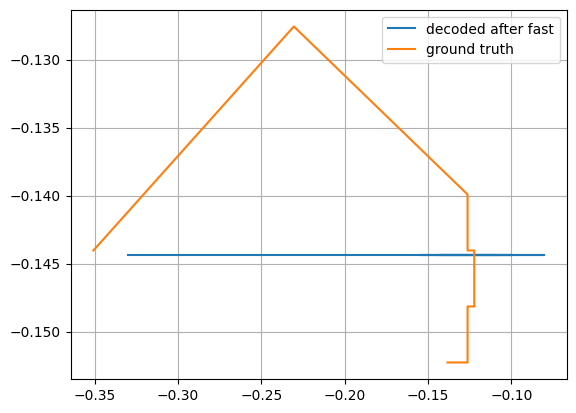

In [44]:

fast_action_tokens = policy.model.fast_tokenizer(batch["action"].detach().cpu())

decoded_actions = torch.tensor(
    [
        policy.model.decode_actions_with_fast(
            [tok],
            time_horizon=policy.model.action_horizon,
            action_dim=policy.model.action_dim,
            relaxed_decoding=policy.model.config.relaxed_action_decoding,
        ).squeeze(0)
        for tok in fast_action_tokens
    ],
    dtype=torch.float32,
    device=device,
)

error:torch.tensor = torch.sqrt((decoded_actions - batch["action"])**2)

print(f"RMSE {(error.mean(dim=1)*100).tolist()}%")

decoded_data = decoded_actions.cpu()[0]
orig_data = batch["action"].cpu()[0]

print("Distance at 5th:", distance(decoded_data, orig_data, 4))
print("Distance at 10th:", distance(decoded_data, orig_data, 9))


plt.plot(decoded_data[:, 0], decoded_data[:, 1], label="decoded after fast")
plt.plot(orig_data[:, 0], orig_data[:, 1], label="ground truth")
plt.legend()
plt.grid()
plt.show()
